## 사용할 패키지

In [1]:
import datetime
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
import lightgbm as lgb
import xgboost as xgb

In [3]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

## 데이터 불러오기

In [4]:
site = pd.read_csv('data/site_info.csv')
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('data/ulsan_fcst_data.csv')

기상 예보는 전날 23시(오후 11시) 예보를 선형보간하여 사용하였습니다.

※ 기상 예보 전치리 과정 : https://dacon.io/competitions/official/235720/codeshare/2499?page=1&dtype=recent

In [5]:
forecast_t = 23

In [6]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [7]:
dangjin_fcst_t = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==forecast_t]
ulsan_fcst_t = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==forecast_t]

In [8]:
dangjin_fcst_t = dangjin_fcst_t[(dangjin_fcst_t['forecast'] >= (24 - forecast_t))&(dangjin_fcst_t['forecast'] <= (47 - forecast_t))]
ulsan_fcst_t = ulsan_fcst_t[(ulsan_fcst_t['forecast'] >= (24 - forecast_t))&(ulsan_fcst_t['forecast'] <= (47 - forecast_t))]

In [9]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_t['Forecast_time'] = dangjin_fcst_t['Forecast_time'] + dangjin_fcst_t['forecast'].map(to_date)
ulsan_fcst_t['Forecast_time'] = ulsan_fcst_t['Forecast_time'] + ulsan_fcst_t['forecast'].map(to_date)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\arrays\datetimelike.py:1111: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [10]:
dangjin_fcst_t = dangjin_fcst_t[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_t = ulsan_fcst_t[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [11]:
dangjin_fcst_t_ = pd.DataFrame()
dangjin_fcst_t_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_t_ = pd.DataFrame()
ulsan_fcst_t_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [12]:
dangjin_fcst_t_ = pd.merge(dangjin_fcst_t_, dangjin_fcst_t, on='Forecast_time', how='outer')
ulsan_fcst_t_ = pd.merge(ulsan_fcst_t_, ulsan_fcst_t, on='Forecast_time', how='outer')

In [13]:
dangjin_fcst = dangjin_fcst_t_.interpolate()
ulsan_fcst = ulsan_fcst_t_.interpolate()

In [14]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

## 풍향 벡터 사용

In [15]:
def transform_wind_to_vector(df_):
    df = df_.copy()

    wv = df['WindSpeed']

    # Convert to radians.
    wd_rad = df['WindDirection']*np.pi / 180

    # Calculate the wind x and y components.
    df['Wind_X'] = wv*np.cos(wd_rad)
    df['Wind_Y'] = wv*np.sin(wd_rad)
    
    return df

In [16]:
dangjin_fcst = transform_wind_to_vector(dangjin_fcst)
ulsan_fcst = transform_wind_to_vector(ulsan_fcst)

## 타임 시그널 변환

In [17]:
def transform_datetime_to_signal(df_):
    df = df_.copy()
    date_time = pd.to_datetime(df['Forecast_time'], format='%Y.%m.%d %H:%M')
    timestamp_s = date_time.map(datetime.datetime.timestamp)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return df

In [18]:
dangjin_fcst = transform_datetime_to_signal(dangjin_fcst)
ulsan_fcst = transform_datetime_to_signal(ulsan_fcst)

In [19]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-3.000000,55.000000,5.0,339.000000,1.0,4.667902,-1.791840,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-3.333333,56.666667,4.7,343.666667,1.0,4.510317,-1.321758,-0.965926,2.588190e-01,0.859748,0.510719


In [20]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-1.0,45.0,1.8,299.000000,2.000000,0.872657,-1.574315,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-1.0,45.0,1.8,300.666667,1.666667,0.918077,-1.548268,-0.965926,2.588190e-01,0.859748,0.510719


## 일사량 추가하기

In [21]:
# Python Sun Position for Solar Energy and Research
# https://levelup.gitconnected.com/python-sun-position-for-solar-energy-and-research-7a4ead801777
# sunpos.pyimport math

def sunpos(year, month, day, hour, timezone, latitude, longitude, refraction): # Extract the passed data
    rad, deg = np.radians, np.degrees
    sin, cos, tan = np.sin, np.cos, np.tan
    asin, atan2 = np.arcsin, np.arctan2 

    # Convert latitude and longitude to radians
    rlat = rad(latitude)
    rlon = rad(longitude) 
    
    # Decimal hour of the day at Greenwich
    greenwichtime = hour - timezone 

    # Days from J2000, accurate from 1901 to 2099
    daynum = (
        367 * year
        - 7 * (year + (month + 9) // 12) // 4
        + 275 * month // 9
        + day
        - 730531.5
        + greenwichtime / 24
    )

    # Mean longitude of the sun
    mean_long = daynum * 0.01720279239 + 4.894967873 
    # Mean anomaly of the Sun
    mean_anom = daynum * 0.01720197034 + 6.240040768 

    # Ecliptic longitude of the sun
    eclip_long = (mean_long + 0.03342305518 * sin(mean_anom) + 0.0003490658504 * sin(2 * mean_anom))
    # Obliquity of the ecliptic
    obliquity = 0.4090877234 - 0.000000006981317008 * daynum 
    # Right ascension of the sun
    rasc = atan2(cos(obliquity) * sin(eclip_long), cos(eclip_long)) 
    # Declination of the sun
    decl = asin(sin(obliquity) * sin(eclip_long)) 
    # Local sidereal time
    sidereal = 4.894961213 + 6.300388099 * daynum + rlon 
    # Hour angle of the sun
    hour_ang = sidereal - rasc 
    # Local elevation of the sun
    elevation = asin(sin(decl) * sin(rlat) + cos(decl) * cos(rlat) * cos(hour_ang)) 
    # Local azimuth of the sun
    azimuth = atan2(-cos(decl) * cos(rlat) * sin(hour_ang), sin(decl) - sin(rlat) * sin(elevation),) 

    # Convert azimuth and elevation to degrees
    azimuth = into_range(deg(azimuth), 0, 360)
    elevation = into_range(deg(elevation), -180, 180) 

    # Refraction correction (optional)
    if refraction:
        targ = rad((elevation + (10.3 / (elevation + 5.11))))
        elevation += (1.02 / tan(targ)) / 60 

    # Return azimuth and elevation in degrees
    return (round(azimuth, 2), round(elevation, 2))
    
def into_range(x, range_min, range_max):
    shiftedx = x - range_min
    delta = range_max - range_min
    return (((shiftedx % delta) + delta) % delta) + range_min

In [22]:
def directInsolation(altitude):                             # 직사 일사량
    am = 1/np.cos(np.radians(90 - altitude))                # airmass
    I = 1.353 * 0.7 ** (am ** 0.678)                        # direct insolation
    return I

In [23]:
# Test code
azimuth, elevation = sunpos(2018, 3, 2, 0, 9, 37.0507527, 126.5102993, True)
print("\nWhen: ", (2018, 3, 2, 0, 9))
print("Where: ", (37.0507527, 126.5102993))
print("Azimuth: ", azimuth)
print("Elevation: ", elevation)
# When:  (2018, 3, 2, 0, 9)
# Where:  (37.0507527, 126.5102993)
# Azimuth:  337.58
# Elevation:  -58.59


When:  (2018, 3, 2, 0, 9)
Where:  (37.0507527, 126.5102993)
Azimuth:  337.58
Elevation:  -58.59


In [24]:
def add_insolation(df_, latitude, longitude, timezone):
    location = ()

    df_['date'] = df_['Forecast_time'].str.split(' ').str[0]
    df_['hour'] = df_['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

    df_['year'] = df_['date'].str.split('-').str[0].astype(float)
    df_['month'] = df_['date'].str.split('-').str[1].astype(int)
    df_['day'] = df_['date'].str.split('-').str[2].astype(int)

    df_['azimuth'], df_['elevation'] = sunpos(df_['year'], df_['month'], df_['day'], df_['hour'], timezone, latitude, longitude, True)
    
    df_.loc[df_['elevation'] < 0, 'azimuth'] = 0
    df_.loc[df_['elevation'] < 0, 'elevation'] = 0

    df_['insolation'] = directInsolation(df_['elevation'])

    return df_

In [25]:
timezone = 9 # GMT+9

dangjin_latitude = float(site.loc[site['Id'] == '당진태양광', 'Latitude'])
dangjin_longitude = float(site.loc[site['Id'] == '당진태양광', 'Longitude'])

ulsan_latitude = float(site.loc[site['Id'] == '울산태양광', 'Latitude'])
ulsan_longitude = float(site.loc[site['Id'] == '울산태양광', 'Longitude'])

dangjin_fcst = add_insolation(dangjin_fcst, dangjin_latitude, dangjin_longitude, timezone)
ulsan_fcst = add_insolation(ulsan_fcst, ulsan_latitude, ulsan_longitude, timezone)

In [26]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,date,hour,year,month,day,azimuth,elevation,insolation
0,2018-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.071068e-01,-7.071068e-01,0.858280,0.513182,2018-03-02,0,2018.0,3,2,0.0,0.0,0.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.660254e-01,-5.000000e-01,0.858648,0.512566,2018-03-02,1,2018.0,3,2,0.0,0.0,0.0
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.659258e-01,-2.588190e-01,0.859015,0.511951,2018-03-02,2,2018.0,3,2,0.0,0.0,0.0
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000e+00,-3.848660e-12,0.859382,0.511335,2018-03-02,3,2018.0,3,2,0.0,0.0,0.0
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-9.659258e-01,2.588190e-01,0.859748,0.510719,2018-03-02,4,2018.0,3,2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0,7.001396,2.594527,5.000000e-01,-8.660254e-01,0.858846,0.512234,2021-03-01,19,2021.0,3,1,0.0,0.0,0.0
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0,6.716573,2.943710,2.588190e-01,-9.659258e-01,0.859213,0.511618,2021-03-01,20,2021.0,3,1,0.0,0.0,0.0
26301,2021-03-01 21:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,4.907520e-12,-1.000000e+00,0.859579,0.511002,2021-03-01,21,2021.0,3,1,0.0,0.0,0.0
26302,2021-03-01 22:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,-2.588190e-01,-9.659258e-01,0.859945,0.510386,2021-03-01,22,2021.0,3,1,0.0,0.0,0.0


In [27]:
ulsan_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,date,hour,year,month,day,azimuth,elevation,insolation
0,2018-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.071068e-01,-7.071068e-01,0.858280,0.513182,2018-03-02,0,2018.0,3,2,0.0,0.0,0.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.660254e-01,-5.000000e-01,0.858648,0.512566,2018-03-02,1,2018.0,3,2,0.0,0.0,0.0
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.659258e-01,-2.588190e-01,0.859015,0.511951,2018-03-02,2,2018.0,3,2,0.0,0.0,0.0
3,2018-03-02 03:00:00,-1.0,45.0,1.800000,299.000000,2.000000,0.872657,-1.574315,-1.000000e+00,-3.848660e-12,0.859382,0.511335,2018-03-02,3,2018.0,3,2,0.0,0.0,0.0
4,2018-03-02 04:00:00,-1.0,45.0,1.800000,300.666667,1.666667,0.918077,-1.548268,-9.659258e-01,2.588190e-01,0.859748,0.510719,2018-03-02,4,2018.0,3,2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,16.0,80.0,6.133333,135.333333,4.000000,-4.362079,4.311617,5.000000e-01,-8.660254e-01,0.858846,0.512234,2021-03-01,19,2021.0,3,1,0.0,0.0,0.0
26300,2021-03-01 20:00:00,15.0,80.0,4.966667,83.666667,4.000000,0.547886,4.936355,2.588190e-01,-9.659258e-01,0.859213,0.511618,2021-03-01,20,2021.0,3,1,0.0,0.0,0.0
26301,2021-03-01 21:00:00,14.0,80.0,3.800000,32.000000,4.000000,3.222583,2.013693,4.907520e-12,-1.000000e+00,0.859579,0.511002,2021-03-01,21,2021.0,3,1,0.0,0.0,0.0
26302,2021-03-01 22:00:00,14.0,80.0,3.800000,32.000000,4.000000,3.222583,2.013693,-2.588190e-01,-9.659258e-01,0.859945,0.510386,2021-03-01,22,2021.0,3,1,0.0,0.0,0.0


In [28]:
dangjin_fcst.to_csv("data/add_dangjin_wind_time_insolation.csv", index=False)
ulsan_fcst.to_csv("data/add_ulsan_wind_time_insolation.csv", index=False)

## 학습 데이터 전처리

In [29]:
def make_train_data(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[[#'year', 'month', 'day', 'hour', 
                            'Year sin', 'Year cos', 'Day sin', 'Day cos',
                            'Temperature', 'Humidity', 
                            #'WindSpeed', 'WindDirection',
                            'Wind_X', 'Wind_Y',
                            'azimuth', 'elevation', 'insolation',
                            'Cloud', target]]


    x_df = feature_df.loc[:, :'Cloud']
    y_df = feature_df[target]

    return x_df, y_df

In [30]:
def train_dataset(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[[#'year', 'month', 'day', 'hour', 
                            'Year sin', 'Year cos', 'Day sin', 'Day cos',
                            'Temperature', 'Humidity', 
                            #'WindSpeed', 'WindDirection',
                            'Wind_X', 'Wind_Y',
                            'azimuth', 'elevation', 'insolation',
                            'Cloud', target]]

    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, :'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, :'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## 테스트 데이터 전처리

In [31]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df = test_df[[ #'year', 'month', 'day', 'hour', 
                        'Year sin', 'Year cos', 'Day sin', 'Day cos',
                        'Temperature', 'Humidity', 
                        #'WindSpeed', 'WindDirection',
                        'Wind_X', 'Wind_Y',
                        'azimuth', 'elevation', 'insolation',
                        'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [32]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

## LightGBM Custom Metric

In [33]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [34]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [35]:
# params = {
#     'seed':42,
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'metric':'mae',
#     'num_iterations': 10000,
#     'learning_rate': 0.01,
# #     'max_depth': -1, # 최대 깊이 트리를 만듬
#     'max_depth': 16,
#     'num_leaves': 39000,
#     'bagging_freq': 2,
#     'bagging_fraction': 0.7,
#     'feature_fraction': 0.8,
# }

## Optuna Hyperparameter Setting

In [36]:
# # 기본 패러미터
# params_default = {
#         'seed':42,
#         'boosting': 'gbdt',
#         'objective': 'regression',
#         'metric':'mae',
#         'num_iterations': 10000,
#         'learning_rate': 0.01,
# }

In [37]:
# # 기본 패러미터
# params_default = {
#     'verbose': -1,
#     'seed': 2021,
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'metric':'mae',
#     'learning_rate': 0.09,
# }

In [38]:
# def objectiveLGBM(trial: Trial, energy, fcst, target):
#     params = {
#         'verbose': -1,
#         'seed': 2021,
#         'boosting': 'gbdt',
#         'objective': 'regression',
#         'metric':'mse',
#         'learning_rate': 0.09,
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 65535),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 0, 5),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 1.5),
#         'max_bin': trial.suggest_int('max_bin', 1, 1000)
#     }

#     train_x, train_y, val_x, val_y = train_dataset(energy, fcst, target)
#     train_ds = lgb.Dataset(train_x, train_y)
#     val_ds = lgb.Dataset(val_x, val_y)

#     model = lgb.train(params=params, train_set=train_ds, num_boost_round=1000, valid_sets=val_ds, verbose_eval=50, early_stopping_rounds=30, feval=nmae_10)

#     pred = model.predict(val_x)
#     score = sola_nmae(val_y, pred)

#     return score

In [39]:
# 패러미터 그래프가 궁금할때 쓰는 코드들
# # 하이퍼파라미터 최적화 과정을 확인
# optuna.visualization.plot_optimization_history(study)

# # 하이퍼파라미터별 중요도
# optuna.visualization.plot_param_importances(study)

# # 파라미터들관의 관계
# optuna.visualization.plot_parallel_coordinate(study)

In [40]:
# def paramsTuning(energy, fcst, target):
#     sampler = TPESampler()
#     study = optuna.create_study(
#         study_name="lgbm_parameter_opt",
#         direction="minimize",
#         sampler=sampler,
#     )
#     study.optimize(lambda trial: objectiveLGBM(trial, energy, fcst, target), n_trials=10)
#     print()
#     print("Best Score:", study.best_value)
#     print("Best trial:", study.best_trial.params)
#     return study

## K-Fold

In [41]:
def kfold_lgbm(params, n_split, energy, fcst, test_set, target):
    cv_score = 0
    cv_predict = np.zeros((test_set.shape[0]), dtype=float)
    x_df, y_df = make_train_data(energy, fcst, target)

    folds = KFold(n_splits=n_split, shuffle=True, random_state=42)
    splits = folds.split(x_df, y_df)

    for index, (train_idx, valid_idx) in enumerate(splits):
        print(f"============ Fold {index} ============\n")
        train_x, val_x = x_df.iloc[train_idx].to_numpy(), x_df.iloc[valid_idx].to_numpy()
        train_y, val_y = y_df.iloc[train_idx].to_numpy(), y_df.iloc[valid_idx].to_numpy()

        # # 발전량이 0인 데이터를 제외
        # train_x = train_x[train_y[target]!=0]
        # train_y = train_y[train_y[target]!=0]

        train_ds = lgb.Dataset(train_x, train_y)
        val_ds = lgb.Dataset(val_x, val_y)

        model = lgb.train(params=params, train_set=train_ds, num_boost_round=1000, valid_sets=val_ds, verbose_eval=500, early_stopping_rounds=30, feval=nmae_10)

        cv_score += sola_nmae(val_y, model.predict(val_x))
        cv_predict += model.predict(test_set)

    print('CV Mean Score : ', cv_score/n_split)
    predict = cv_predict/n_split

    return predict
    

### 하이퍼 파라미터 추출

In [42]:
# # 당진수상태양광
# capacity = 1000

# study = paramsTuning(energy, dangjin_fcst, target='dangjin_floating')

# params_floating = params_default.copy()
# params_floating.update(study.best_trial.params)
# print(params_floating)

In [43]:
# # 하이퍼파라미터 최적화 과정을 확인
# optuna.visualization.plot_optimization_history(study)

In [44]:
# # 하이퍼파라미터별 중요도
# optuna.visualization.plot_param_importances(study)

In [45]:
# # 파라미터들관의 관계
# optuna.visualization.plot_parallel_coordinate(study)

In [46]:
# # 당진자재창고태양광
# capacity = 700

# study = paramsTuning(energy, dangjin_fcst, target='dangjin_warehouse')

# params_warehouse = params_default.copy()
# params_warehouse.update(study.best_trial.params)
# print(params_warehouse)

In [47]:
# # 당진태양광
# capacity = 1000

# study = paramsTuning(energy, dangjin_fcst, target='dangjin')

# params_dangjin = params_default.copy()
# params_dangjin.update(study.best_trial.params)
# print(params_dangjin)

In [48]:
# # 울산태양광
# capacity = 500

# study = paramsTuning(energy, ulsan_fcst, target='ulsan')

# params_ulsan = params_default.copy()
# params_ulsan.update(study.best_trial.params)
# print(params_ulsan)

### 예측 모델 학습

In [49]:
params_floating = {
    'verbose': -1, 
    'seed': 2021, 
    'boosting': 
    'gbdt', 
    'objective': 'regression', 
    'metric': 'mae', 
    'learning_rate': 0.09, 
    'max_depth': 20, 
    'num_leaves': 32798, 
    'min_data_in_leaf': 39, 
    'lambda_l1': 4.561094684897773, 
    'lambda_l2': 8.888899325305871, 
    'bagging_freq': 0, 
    'bagging_fraction': 0.6787974978388922, 
    'feature_fraction': 0.43390142278286126, 
    'scale_pos_weight': 1.0564229411526196, 
    'max_bin': 784
    }

params_warehouse = {
    'verbose': -1, 
    'seed': 2021, 
    'boosting': 'gbdt', 
    'objective': 'regression', 
    'metric': 'mae', 
    'learning_rate': 0.09, 
    'max_depth': 8, 
    'num_leaves': 59700, 
    'min_data_in_leaf': 73, 
    'lambda_l1': 4.771046461475887, 
    'lambda_l2': 6.181630028245978, 
    'bagging_freq': 0, 
    'bagging_fraction': 0.4980967681726417, 
    'feature_fraction': 0.4038783769693114, 
    'scale_pos_weight': 1.203886552860244, 
    'max_bin': 748
    }

params_dangjin = {
    'verbose': -1, 
    'seed': 2021, 
    'boosting': 'gbdt', 
    'objective': 'regression', 
    'metric': 'mae', 
    'learning_rate': 0.09, 
    'max_depth': 13, 
    'num_leaves': 35900, 
    'min_data_in_leaf': 101, 
    'lambda_l1': 4.146032507218709, 
    'lambda_l2': 2.654270912625294, 
    'bagging_freq': 3, 
    'bagging_fraction': 0.9980740682405935, 
    'feature_fraction': 0.4414072304994734, 
    'scale_pos_weight': 1.4545059935564075, 
    'max_bin': 44
    }

params_ulsan = {
    'verbose': -1, 
    'seed': 2021, 
    'boosting': 'gbdt', 
    'objective': 'regression', 
    'metric': 'mae', 
    'learning_rate': 0.09, 
    'max_depth': 10, 
    'num_leaves': 18195, 
    'min_data_in_leaf': 87, 
    'lambda_l1': 9.936206855210838, 
    'lambda_l2': 1.8092783404797308, 
    'bagging_freq': 2, 
    'bagging_fraction': 0.870534721153838, 
    'feature_fraction': 0.5867434734948355, 
    'scale_pos_weight': 1.0801917134933015, 
    'max_bin': 880}

In [50]:
# # 당진수상태양광 예측 모델 학습
# capacity = 1000
# dangjin_floating_pred = kfold_lgbm(params_floating, 5, energy, dangjin_fcst, dangjin_test, target='dangjin_floating')

In [51]:
# # 당진자재창고태양광 예측 모델 학습
# capacity = 700
# dangjin_warehouse_pred = kfold_lgbm(params_warehouse, 5, energy, dangjin_fcst, dangjin_test, target='dangjin_warehouse')

In [52]:
# # 당진태양광 예측 모델 학습
# capacity = 1000
# dangjin_pred = kfold_lgbm(params_dangjin, 5, energy, dangjin_fcst, dangjin_test, target='dangjin')

In [53]:
# # 울산태양광 예측 모델 학습
# capacity = 500
# ulsan_pred = kfold_lgbm(params_ulsan, 5, energy, ulsan_fcst, ulsan_test, target='ulsan')

### private 예측 모델 학습

In [54]:
def test_datast_private(fcst_df, latitude, longitude, timezone):
    fcst_df['Forecast_time'] = fcst_df['Forecast_time'].astype(str)
    fcst_df = transform_wind_to_vector(fcst_df)
    fcst_df = transform_datetime_to_signal(fcst_df)
    fcst_df = add_insolation(fcst_df, latitude, longitude, timezone)

    test_df = fcst_df[[ #'year', 'month', 'day', 'hour', 
                        'Year sin', 'Year cos', 'Day sin', 'Day cos',
                        'Temperature', 'Humidity', 
                        #'WindSpeed', 'WindDirection',
                        'Wind_X', 'Wind_Y',
                        'azimuth', 'elevation', 'insolation',
                        'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [6]:
fcst_date = '2021-06-14'
day_after = 5

In [7]:
dangjin_fcst_priv = pd.read_csv(f'private_test/ulsan_fcst_{fcst_date}.csv')
ulsan_fcst_priv = pd.read_csv(f'private_test/ulsan_fcst_{fcst_date}.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'private_test/ulsan_fcst_2021-06-14.csv'

In [57]:
dangjin_test_priv = test_datast_private(dangjin_fcst_priv, dangjin_latitude, dangjin_longitude, timezone)
ulsan_test_priv = test_datast_private(ulsan_fcst_priv, ulsan_latitude, ulsan_longitude, timezone)

In [58]:
# 당진수상태양광 예측 모델 학습
capacity = 1000
dangjin_floating_pred_priv = kfold_lgbm(params_floating, 20, energy, dangjin_fcst, dangjin_test_priv, target='dangjin_floating')

============ Fold 0 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[211]	valid_0's l1: 26.6665	valid_0's score: 5.76904
============ Fold 1 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[257]	valid_0's l1: 28.3954	valid_0's score: 6.08314
============ Fold 2 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[403]	valid_0's l1: 26.8359	valid_0's score: 6.12852
============ Fold 3 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[367]	valid_0's l1: 25.9739	valid_0's score: 5.88494
============ Fold 4 ============

Training until validation scores don't improve for 30 rounds
[500]	valid_0's l1: 29.1476	valid_0's score: 6.22617
Early stopping, best iteration is:
[545]	valid_0's l1: 29.0464	valid_0's score: 6.20466
============ Fold 5 ============

In [59]:
# 당진자재창고태양광 예측 모델 학습
capacity = 700
dangjin_warehouse_pred_priv = kfold_lgbm(params_warehouse, 20, energy, dangjin_fcst, dangjin_test_priv, target='dangjin_warehouse')

============ Fold 0 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[327]	valid_0's l1: 21.5482	valid_0's score: 6.82541
============ Fold 1 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[242]	valid_0's l1: 22.9307	valid_0's score: 7.09383
============ Fold 2 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[173]	valid_0's l1: 23.5427	valid_0's score: 7.4135
============ Fold 3 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 21.9134	valid_0's score: 7.30451
============ Fold 4 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[245]	valid_0's l1: 23.6761	valid_0's score: 7.42451
============ Fold 5 ============

Training until validation scores don't improve for 3

In [60]:
# 당진태양광 예측 모델 학습
capacity = 1000
dangjin_pred_priv = kfold_lgbm(params_dangjin, 20, energy, dangjin_fcst, dangjin_test_priv, target='dangjin')

============ Fold 0 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[143]	valid_0's l1: 31.4799	valid_0's score: 7.14077
============ Fold 1 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[253]	valid_0's l1: 33.8278	valid_0's score: 7.41348
============ Fold 2 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[247]	valid_0's l1: 33.7084	valid_0's score: 7.76867
============ Fold 3 ============

Training until validation scores don't improve for 30 rounds
[500]	valid_0's l1: 31.9618	valid_0's score: 7.25569
Early stopping, best iteration is:
[512]	valid_0's l1: 31.9296	valid_0's score: 7.24632
============ Fold 4 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 36.625	valid_0's score: 8.36505
============ Fold 5 ============


In [61]:
# 울산태양광 예측 모델 학습
capacity = 500
ulsan_pred_priv = kfold_lgbm(params_ulsan, 20, energy, ulsan_fcst, ulsan_test_priv, target='ulsan')

============ Fold 0 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 14.7294	valid_0's score: 6.64746
============ Fold 1 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[254]	valid_0's l1: 15.3338	valid_0's score: 6.70686
============ Fold 2 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[170]	valid_0's l1: 14.9757	valid_0's score: 6.76048
============ Fold 3 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 13.4048	valid_0's score: 6.44893
============ Fold 4 ============

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[161]	valid_0's l1: 14.3041	valid_0's score: 6.47389
============ Fold 5 ============

Training until validation scores don't improve for 

## 각 발전소 발전량 추론

In [62]:
# plt.figure(figsize=(20,5))
# plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
# plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
# plt.plot(dangjin_pred, label = 'dangjin_pred')
# plt.plot(ulsan_pred, label = 'ulsan_pred')
# plt.legend()
# plt.show()

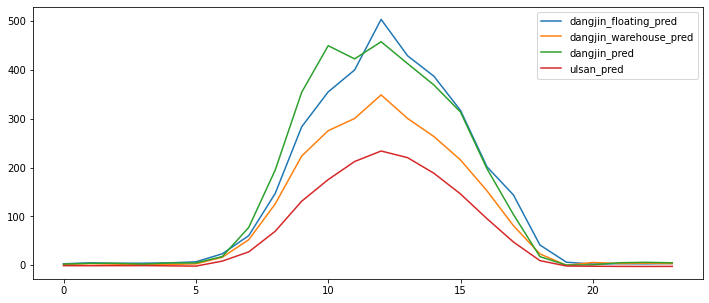

In [63]:
plt.figure(figsize=(12,5))
plt.plot(dangjin_floating_pred_priv, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred_priv, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred_priv, label = 'dangjin_pred')
plt.plot(ulsan_pred_priv, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [64]:
# submission = pd.read_csv('data/sample_submission.csv')

In [65]:
# submission.iloc[:24*28, 1] = dangjin_floating_pred
# submission.iloc[:24*28, 2] = dangjin_warehouse_pred
# submission.iloc[:24*28, 3] = dangjin_pred
# submission.iloc[:24*28, 4] = ulsan_pred

In [66]:
# submission

In [67]:
# submission.to_csv('final_submission.csv', index=False)

In [68]:
submission_priv = pd.read_csv('final_submission.csv')

In [69]:
submission_priv.iloc[24*(28+day_after):24*(28+day_after+1), 1] = dangjin_floating_pred_priv
submission_priv.iloc[24*(28+day_after):24*(28+day_after+1), 2] = dangjin_warehouse_pred_priv
submission_priv.iloc[24*(28+day_after):24*(28+day_after+1), 3] = dangjin_pred_priv
submission_priv.iloc[24*(28+day_after):24*(28+day_after+1), 4] = ulsan_pred_priv

In [70]:
submission_priv[24*(28+day_after):24*(28+day_after+1)]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
792,2021-06-14 01:00:00,2.836011,1.355576,2.145727,-1.016463
793,2021-06-14 02:00:00,4.693496,3.043951,3.912643,-1.129371
794,2021-06-14 03:00:00,3.792495,1.996605,3.768487,-1.023300
795,2021-06-14 04:00:00,3.993227,0.941120,2.303340,-0.946697
796,2021-06-14 05:00:00,4.693684,1.552769,4.422944,-1.398959
797,2021-06-14 06:00:00,6.814523,2.582813,4.491991,-1.994216
798,2021-06-14 07:00:00,23.238781,16.223670,17.587970,8.321841
799,2021-06-14 08:00:00,60.513038,52.151595,77.434591,27.247583
800,2021-06-14 09:00:00,147.078682,125.585590,194.944568,69.490448
801,2021-06-14 10:00:00,283.482126,223.571666,354.256534,131.027429


In [71]:
submission_priv.to_csv('final_submission.csv', index=False)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_fcst['Insolation'] * 1000, label='Insolation')
plt.plot(energy['dangjin_floating'], label='dangjin_floating')
#plt.plot([declination(i/10) for i in range(3650)], label='true')
plt.legend()
plt.show()

In [ ]:
# 일기 예보 있는 날짜만 선택
energy_ = energy.loc[24:]
energy_.index = range(energy_.shape[0])

# 발전량 데이터가 있는 날짜만 선택
dangjin_fcst_ = dangjin_fcst.loc[:25608-1]
dangjin_fcst_.index = range(dangjin_fcst_.shape[0])

# 예보 시간 및 날짜 정보 feature로 추가
dangjin_fcst_['date'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[0]
dangjin_fcst_['hour'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

dangjin_fcst_['year'] = dangjin_fcst_['date'].str.split('-').str[0].astype(int)
dangjin_fcst_['month'] = dangjin_fcst_['date'].str.split('-').str[1].astype(int)
dangjin_fcst_['day'] = dangjin_fcst_['date'].str.split('-').str[2].astype(int)

# 발전량과 일기예보 연결
heat_df = pd.concat([energy_, dangjin_fcst_], axis=1)
heat_df = heat_df[[ #'month', 'hour', 'day', 'hour',
                    #'Year sin', 'Year cos', 'Day sin', 'Day cos',
                    'Temperature', 'Humidity', 
#                     'WindSpeed', 'WindDirection',
                    'Wind_X', 'Wind_Y',
                    'Insolation',
                    'Cloud',
                    'dangjin']]

In [ ]:
heat_corr = heat_df.corr()

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(data = heat_corr, annot=True, fmt = '.2f')